In [1]:
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', 1000)

import cv2
from pathlib import Path
import random
from tqdm import tqdm

import re

import torch
from torch.utils.data import Dataset

import torchvision
from torchvision.transforms import Normalize
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import nms

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

torch.manual_seed(3)
torch.cuda.manual_seed(3)
torch.cuda.manual_seed_all(3)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(3)
random.seed(3)

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="albumentations")

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
PATH = '/kaggle/input/ghana-crop-disease/'
IMG_PATH = '/kaggle/input/ghana-crop-disease/images/'

In [3]:
def display_image_by_id(image_id):
    # Construct the file path
    image_path = os.path.join(IMAGE_DIR, f"{image_id}.jpg")
    
    # Check if the file exists
    if os.path.exists(image_path):
        # Load the image
        image = Image.open(image_path)
        
        # Display the image
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Image_ID: {image_id}")
        plt.show()
    else:
        print(f"Image with ID {image_id} not found.")

In [4]:
train = pd.read_csv(f"{PATH}Train.csv")
test = pd.read_csv(f"{PATH}Test.csv")
ss = pd.read_csv(f"{PATH}SampleSubmission.csv")

In [5]:
train["plant"] = train["class"].apply(lambda x: x.split("_")[0])
train["disease"] = train["class"].apply(lambda x: "_".join(x.split("_")[1:]))

In [6]:
train.columns

Index(['Image_ID', 'confidence', 'class', 'ymin', 'xmin', 'ymax', 'xmax',
       'plant', 'disease'],
      dtype='object')

In [7]:
train['class_id'] = train['class'].map(
    {'Pepper_Bacterial_Spot': 0, 'Pepper_Fusarium': 1, 'Corn_Cercospora_Leaf_Spot': 2, 'Corn_Common_Rust': 3, 'Tomato_Early_Blight': 4, 'Pepper_Septoria': 5, 'Tomato_Septoria': 6, 'Pepper_Leaf_Curl': 7, 'Pepper_Leaf_Mosaic': 8, 'Corn_Streak': 9, 'Corn_Healthy': 10, 'Pepper_Healthy': 11, 'Tomato_Healthy': 12, 'Pepper_Late_Blight': 13, 'Tomato_Late_Blight': 14, 'Pepper_Cercospora': 15, 'Tomato_Fusarium': 16, 'Pepper_Leaf_Blight': 17, 'Tomato_Leaf_Curl': 18, 'Tomato_Bacterial_Spot': 19, 'Tomato_Mosaic': 20, 'Pepper_Early_Blight': 21, 'Corn_Northern_Leaf_Blight': 22})

In [8]:
image_ids = train['Image_ID'].unique()
# Stratified split based on the 'category_id' column
train_ids, valid_ids = train_test_split(image_ids, test_size=0.1, stratify=train.groupby('Image_ID')['class_id'].apply(lambda x: x.iloc[0]), random_state=3)

# Filter dataframe based on split
valid_df = train[train['Image_ID'].isin(valid_ids)]
train_df = train[train['Image_ID'].isin(train_ids)]

In [9]:
train_df.shape, valid_df.shape

((36879, 10), (4150, 10))

# Data Loading

In [10]:
class CropDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['Image_ID'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        records = self.df[self.df['Image_ID'] == image_id]

        # Load and preprocess the image
        image = cv2.imread(f'{self.image_dir}{image_id}', cv2.IMREAD_COLOR)  # Adjust extension as necessary
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        height, width, _ = image.shape
        image /= 255.0

        # Get bounding box coordinates in (ymin, xmin, ymax, xmax) format
        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values

        # Ensure bounding boxes are valid
        if ((boxes[:, 2] - boxes[:, 0]) <= 0).any() or ((boxes[:, 3] - boxes[:, 1]) <= 0).any():
            return self.__getitem__(np.random.randint(len(self)))

        # Calculate the area of each box
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        area = torch.as_tensor(area, dtype=torch.float32)

        # Get the class (label) from the 'class' column
        labels = records['class_id'].values
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        target = {
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'labels': labels,
            'image_id': torch.tensor([index]),
            'area': area,
            'iscrowd': iscrowd
        }

        # Apply transforms if provided
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'].tolist(),  # Ensure bboxes are lists
                'labels': labels.tolist()  # Ensure labels are lists
            }
            sample = self.transforms(**sample)
            image = sample['image']
            target['boxes'] = torch.tensor(sample['bboxes'], dtype=torch.float32)
            target['labels'] = torch.tensor(sample['labels'], dtype=torch.int64)

        return image, target, image_id

    def __len__(self) -> int:
        return len(self.image_ids)
    
    def compute_num_categories(self):
        self.num_categories = {}
        for image_id in self.image_ids:
            records = self.df[self.df['Image_ID'] == image_id]
            num_categories = len(records['class_id'].unique())
            self.num_categories[image_id] = num_categories

In [11]:
def get_train_transform():
    return A.Compose([
        A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9),
                               A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9)],p=0.9),
        A.OneOf([A.MotionBlur(p=0.2),
                A.MedianBlur(blur_limit=3, p=0.1),
                A.Blur(blur_limit=3, p=0.1),
            ], p=0.2),
        A.OneOf([
                A.GaussNoise(),
                A.Sharpen(),
                A.Emboss(),
            ], p=0.2),             
        A.HorizontalFlip(p=0.6),
        ToTensorV2(p=1.0),
    ], bbox_params={'format': 'pascal_voc', 'min_area': 1, 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([            
        A.HorizontalFlip(p=0.6),
        ToTensorV2(p=1.0),
    ], bbox_params={'format': 'pascal_voc', 'min_area': 1, 'label_fields': ['labels']})

In [12]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [13]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = CropDataset(train_df, IMG_PATH, get_train_transform())
valid_dataset = CropDataset(valid_df, IMG_PATH, get_valid_transform())

In [14]:
train_dataset.compute_num_categories()
valid_dataset.compute_num_categories()
indices = torch.randperm(len(train_dataset)).tolist()

In [15]:
train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn
)

# Modeling

In [16]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights='FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1')

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:00<00:00, 193MB/s]


In [17]:
num_classes = train.class_id.nunique()+1
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [18]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
cpu_device = torch.device('cpu')

In [19]:
def sample_batch(data_loader, min_categories=2, max_categories=3, batch_size=16):
    while True:
        images, targets, image_ids = next(iter(data_loader))
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        category_labels = [data_loader.dataset.num_categories[image_id] for image_id in image_ids]
        num_categories = len(set(category_labels))
        if min_categories <= num_categories <= max_categories:
            return images[:batch_size], targets[:batch_size], image_ids[:batch_size], category_labels[:batch_size]

In [20]:
images, targets, image_ids, category_labels = sample_batch(train_data_loader)

In [21]:
colors = {
    0: (0, 255, 0),  # Pepper_Bacterial_Spot
    1: (0, 0, 255),  # Pepper_Fusarium
    2: (255, 0, 0),  # Corn_Cercospora_Leaf_Spot
    3: (255, 255, 0),  # Corn_Common_Rust
    4: (255, 165, 0),  # Tomato_Early_Blight
    5: (0, 255, 255),  # Pepper_Septoria
    6: (128, 0, 128),  # Tomato_Septoria
    7: (0, 128, 128),  # Pepper_Leaf_Curl
    8: (255, 192, 203),  # Pepper_Leaf_Mosaic
    9: (128, 128, 0),  # Corn_Streak
    10: (255, 0, 255),  # Corn_Healthy
    11: (128, 128, 128),  # Pepper_Healthy
    12: (192, 192, 192),  # Tomato_Healthy
    13: (255, 255, 255),  # Pepper_Late_Blight
    14: (0, 255, 127),  # Tomato_Late_Blight
    15: (255, 105, 180),  # Pepper_Cercospora
    16: (255, 69, 0),  # Tomato_Fusarium
    17: (255, 99, 71),  # Pepper_Leaf_Blight
    18: (50, 205, 50),  # Tomato_Leaf_Curl
    19: (255, 215, 0),  # Tomato_Bacterial_Spot
    20: (255, 20, 147),  # Tomato_Mosaic
    21: (255, 255, 0),  # Pepper_Early_Blight
    22: (0, 100, 0)  # Corn_Northern_Leaf_Blight
}

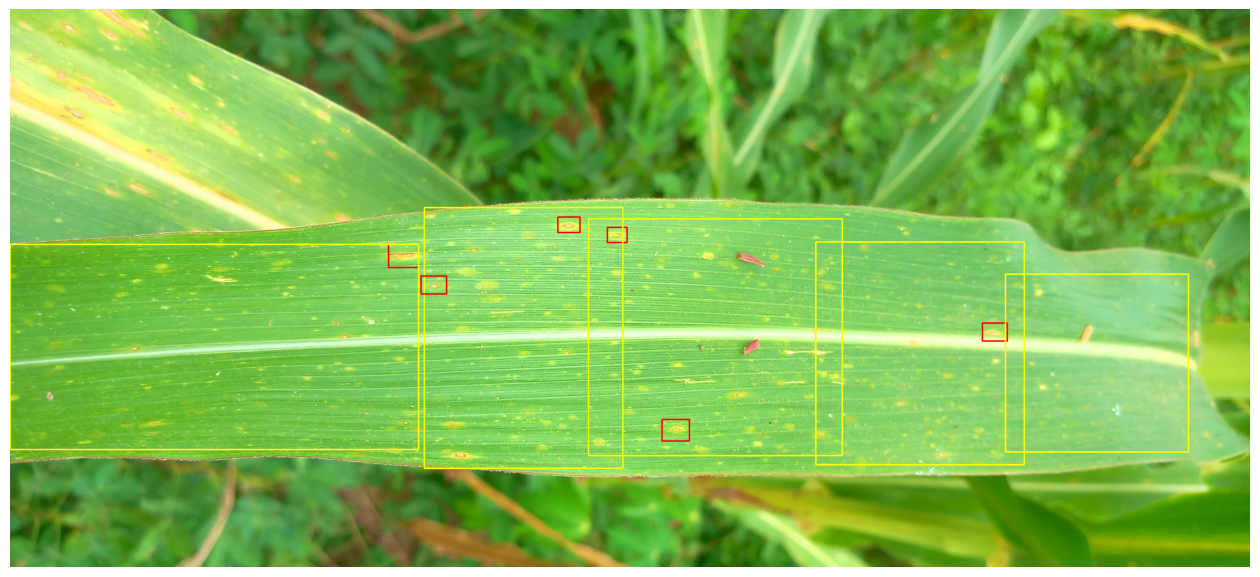

In [22]:
boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
labels = targets[2]['labels'].cpu().numpy()  # Get the correct labels for the bounding boxes
sample = images[2].permute(1, 2, 0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for i in range(len(boxes)):
    box = boxes[i]
    label = labels[i]  # Get label corresponding to the box
    color = colors.get(label, (255, 255, 255))  # Default to white if label is not in colors
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  color, 3)

ax.set_axis_off()
ax.imshow(sample)

In [23]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adagrad(params, lr=0.001, lr_decay=0.00002, weight_decay=0.0005)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, verbose=True, step_size=30, gamma=0.15)
lr_scheduler = None
num_epochs = 8

In [24]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in tqdm(train_data_loader):
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

  5%|▍         | 50/1103 [02:28<47:14,  2.69s/it]

Iteration #50 loss: 1.0613216161727905


  9%|▉         | 100/1103 [05:01<46:46,  2.80s/it]

Iteration #100 loss: 0.7553762793540955


 14%|█▎        | 150/1103 [07:35<54:07,  3.41s/it]  

Iteration #150 loss: 1.0818984508514404


 18%|█▊        | 200/1103 [10:17<55:16,  3.67s/it]

Iteration #200 loss: 0.5695198774337769


 23%|██▎       | 250/1103 [12:56<44:09,  3.11s/it]

Iteration #250 loss: 1.0439746379852295


 27%|██▋       | 300/1103 [15:34<45:29,  3.40s/it]

Iteration #300 loss: 0.8855730891227722


 32%|███▏      | 350/1103 [18:06<35:07,  2.80s/it]

Iteration #350 loss: 0.6632379293441772


 36%|███▋      | 400/1103 [20:54<29:46,  2.54s/it]

Iteration #400 loss: 0.789557933807373


 41%|████      | 450/1103 [23:36<41:30,  3.81s/it]

Iteration #450 loss: 0.8824554085731506


 45%|████▌     | 500/1103 [26:17<27:58,  2.78s/it]

Iteration #500 loss: 0.37443771958351135


 50%|████▉     | 550/1103 [28:53<31:04,  3.37s/it]

Iteration #550 loss: 0.6061930060386658


 54%|█████▍    | 600/1103 [31:24<26:48,  3.20s/it]

Iteration #600 loss: 0.7658313512802124


 59%|█████▉    | 650/1103 [34:04<24:30,  3.25s/it]

Iteration #650 loss: 0.7736590504646301


 63%|██████▎   | 700/1103 [36:38<21:36,  3.22s/it]

Iteration #700 loss: 0.37743180990219116


 68%|██████▊   | 750/1103 [39:08<17:17,  2.94s/it]

Iteration #750 loss: 1.1350765228271484


 73%|███████▎  | 800/1103 [41:42<16:20,  3.24s/it]

Iteration #800 loss: 0.819185197353363


 77%|███████▋  | 850/1103 [44:20<13:38,  3.24s/it]

Iteration #850 loss: 0.680797278881073


 82%|████████▏ | 900/1103 [47:03<14:18,  4.23s/it]

Iteration #900 loss: 1.4975918531417847


 86%|████████▌ | 950/1103 [49:40<06:51,  2.69s/it]

Iteration #950 loss: 0.6825272440910339


 91%|█████████ | 1000/1103 [52:16<05:02,  2.94s/it]

Iteration #1000 loss: 0.7887934446334839


 95%|█████████▌| 1050/1103 [54:56<02:35,  2.93s/it]

Iteration #1050 loss: 1.0560065507888794


100%|█████████▉| 1100/1103 [57:30<00:11,  3.75s/it]

Iteration #1100 loss: 0.24912936985492706


100%|██████████| 1103/1103 [57:39<00:00,  3.14s/it]


Epoch #0 loss: 0.8812324483207649


  4%|▍         | 47/1103 [02:12<50:58,  2.90s/it]

Iteration #1150 loss: 0.43232277035713196


  9%|▉         | 97/1103 [04:38<56:31,  3.37s/it]

Iteration #1200 loss: 1.0534824132919312


 13%|█▎        | 147/1103 [07:02<53:31,  3.36s/it]

Iteration #1250 loss: 0.592005729675293


 18%|█▊        | 197/1103 [09:26<44:46,  2.97s/it]

Iteration #1300 loss: 0.8040577173233032


 22%|██▏       | 247/1103 [11:59<47:29,  3.33s/it]

Iteration #1350 loss: 0.6830328106880188


 27%|██▋       | 297/1103 [14:25<1:02:32,  4.66s/it]

Iteration #1400 loss: 0.654132068157196


 31%|███▏      | 347/1103 [17:02<39:25,  3.13s/it]

Iteration #1450 loss: 0.651296854019165


 36%|███▌      | 397/1103 [19:38<31:52,  2.71s/it]

Iteration #1500 loss: 0.6133611798286438


 41%|████      | 447/1103 [21:59<33:08,  3.03s/it]

Iteration #1550 loss: 0.5823009014129639


 45%|████▌     | 497/1103 [24:32<23:24,  2.32s/it]

Iteration #1600 loss: 0.3729049265384674


 50%|████▉     | 547/1103 [26:50<25:16,  2.73s/it]

Iteration #1650 loss: 0.7363521456718445


 54%|█████▍    | 597/1103 [29:13<25:23,  3.01s/it]

Iteration #1700 loss: 0.9577971696853638


 59%|█████▊    | 647/1103 [31:40<23:34,  3.10s/it]

Iteration #1750 loss: 0.7094470858573914


 63%|██████▎   | 697/1103 [34:15<26:41,  3.94s/it]

Iteration #1800 loss: 1.0365722179412842


 68%|██████▊   | 747/1103 [36:35<17:38,  2.97s/it]

Iteration #1850 loss: 0.7565646767616272


 72%|███████▏  | 797/1103 [38:54<18:03,  3.54s/it]

Iteration #1900 loss: 0.2581886351108551


 77%|███████▋  | 847/1103 [41:24<12:54,  3.02s/it]

Iteration #1950 loss: 0.9712486863136292


 81%|████████▏ | 897/1103 [43:55<11:16,  3.29s/it]

Iteration #2000 loss: 0.8183816075325012


 86%|████████▌ | 947/1103 [46:30<08:37,  3.32s/it]

Iteration #2050 loss: 0.7933247685432434


 90%|█████████ | 997/1103 [49:10<05:17,  3.00s/it]

Iteration #2100 loss: 0.9587571024894714


 95%|█████████▍| 1047/1103 [51:53<02:45,  2.96s/it]

Iteration #2150 loss: 0.9628453254699707


 99%|█████████▉| 1097/1103 [54:25<00:13,  2.22s/it]

Iteration #2200 loss: 0.29547709226608276


100%|██████████| 1103/1103 [54:49<00:00,  2.98s/it]


Epoch #1 loss: 0.7838788798259586


  4%|▍         | 44/1103 [02:13<47:17,  2.68s/it]

Iteration #2250 loss: 0.7974862456321716


  9%|▊         | 94/1103 [04:47<43:53,  2.61s/it]

Iteration #2300 loss: 0.5890904664993286


 13%|█▎        | 144/1103 [07:33<53:15,  3.33s/it]

Iteration #2350 loss: 0.9155375957489014


 18%|█▊        | 194/1103 [10:18<56:15,  3.71s/it]

Iteration #2400 loss: 0.3836410939693451


 22%|██▏       | 244/1103 [12:55<43:07,  3.01s/it]

Iteration #2450 loss: 0.6088347434997559


 27%|██▋       | 294/1103 [15:25<46:26,  3.44s/it]

Iteration #2500 loss: 0.4935292601585388


 31%|███       | 344/1103 [18:08<37:31,  2.97s/it]

Iteration #2550 loss: 0.6569846272468567


 36%|███▌      | 394/1103 [20:43<27:51,  2.36s/it]

Iteration #2600 loss: 0.5491344332695007


 40%|████      | 444/1103 [23:06<32:19,  2.94s/it]

Iteration #2650 loss: 0.7473598718643188


 45%|████▍     | 494/1103 [25:49<28:15,  2.78s/it]

Iteration #2700 loss: 0.8572643399238586


 49%|████▉     | 544/1103 [28:11<24:03,  2.58s/it]

Iteration #2750 loss: 0.783449113368988


 54%|█████▍    | 594/1103 [30:32<30:55,  3.64s/it]

Iteration #2800 loss: 0.2615647614002228


 58%|█████▊    | 644/1103 [33:13<27:51,  3.64s/it]

Iteration #2850 loss: 0.32953426241874695


 63%|██████▎   | 694/1103 [35:47<19:08,  2.81s/it]

Iteration #2900 loss: 0.5945929288864136


 67%|██████▋   | 744/1103 [38:08<17:53,  2.99s/it]

Iteration #2950 loss: 1.253985047340393


 72%|███████▏  | 794/1103 [40:35<16:06,  3.13s/it]

Iteration #3000 loss: 0.4667743742465973


 77%|███████▋  | 844/1103 [43:07<14:29,  3.36s/it]

Iteration #3050 loss: 0.7678613066673279


 81%|████████  | 894/1103 [45:41<09:45,  2.80s/it]

Iteration #3100 loss: 0.6685696840286255


 86%|████████▌ | 944/1103 [48:05<07:18,  2.76s/it]

Iteration #3150 loss: 0.6851924061775208


 90%|█████████ | 994/1103 [50:35<04:48,  2.65s/it]

Iteration #3200 loss: 0.6273167133331299


 95%|█████████▍| 1044/1103 [53:20<03:15,  3.32s/it]

Iteration #3250 loss: 1.7288023233413696


 99%|█████████▉| 1094/1103 [55:43<00:24,  2.68s/it]

Iteration #3300 loss: 0.2354627251625061


100%|██████████| 1103/1103 [56:12<00:00,  3.06s/it]


Epoch #2 loss: 0.7507435191331511


  4%|▎         | 41/1103 [01:59<50:22,  2.85s/it]

Iteration #3350 loss: 1.0044641494750977


  8%|▊         | 91/1103 [04:15<46:36,  2.76s/it]

Iteration #3400 loss: 0.8251572847366333


 13%|█▎        | 141/1103 [06:44<53:56,  3.36s/it]

Iteration #3450 loss: 0.7996509671211243


 17%|█▋        | 191/1103 [09:26<48:10,  3.17s/it]

Iteration #3500 loss: 0.7812464833259583


 22%|██▏       | 241/1103 [12:00<44:11,  3.08s/it]

Iteration #3550 loss: 0.8679428100585938


 26%|██▋       | 291/1103 [14:25<41:14,  3.05s/it]

Iteration #3600 loss: 0.643505334854126


 31%|███       | 341/1103 [17:01<34:28,  2.72s/it]

Iteration #3650 loss: 0.715229332447052


 35%|███▌      | 391/1103 [19:28<31:21,  2.64s/it]

Iteration #3700 loss: 0.4669205844402313


 40%|███▉      | 441/1103 [21:54<30:46,  2.79s/it]

Iteration #3750 loss: 0.8142789006233215


 45%|████▍     | 491/1103 [24:36<27:25,  2.69s/it]

Iteration #3800 loss: 0.9226408004760742


 49%|████▉     | 541/1103 [27:09<26:37,  2.84s/it]

Iteration #3850 loss: 0.5960001945495605


 54%|█████▎    | 591/1103 [29:34<32:57,  3.86s/it]

Iteration #3900 loss: 1.2827033996582031


 58%|█████▊    | 641/1103 [32:07<27:46,  3.61s/it]

Iteration #3950 loss: 0.476673424243927


 63%|██████▎   | 691/1103 [34:43<20:22,  2.97s/it]

Iteration #4000 loss: 0.6287320852279663


 67%|██████▋   | 741/1103 [37:05<16:18,  2.70s/it]

Iteration #4050 loss: 0.5555192232131958


 72%|███████▏  | 791/1103 [39:31<16:59,  3.27s/it]

Iteration #4100 loss: 0.8351458311080933


 76%|███████▌  | 841/1103 [42:04<15:19,  3.51s/it]

Iteration #4150 loss: 0.6340659260749817


 81%|████████  | 891/1103 [44:41<11:45,  3.33s/it]

Iteration #4200 loss: 0.6526088714599609


 85%|████████▌ | 941/1103 [47:14<08:30,  3.15s/it]

Iteration #4250 loss: 0.6642911434173584


 90%|████████▉ | 991/1103 [49:58<05:45,  3.08s/it]

Iteration #4300 loss: 0.6116531491279602


 94%|█████████▍| 1041/1103 [52:34<02:42,  2.62s/it]

Iteration #4350 loss: 0.6743043661117554


 99%|█████████▉| 1091/1103 [55:05<00:38,  3.24s/it]

Iteration #4400 loss: 0.3121236264705658


100%|██████████| 1103/1103 [55:44<00:00,  3.03s/it]


Epoch #3 loss: 0.7195379146368852


  3%|▎         | 38/1103 [01:50<44:59,  2.53s/it]

Iteration #4450 loss: 0.6202722787857056


  8%|▊         | 88/1103 [04:25<59:37,  3.52s/it]  

Iteration #4500 loss: 0.7003505825996399


 13%|█▎        | 138/1103 [07:06<52:35,  3.27s/it]

Iteration #4550 loss: 0.671989381313324


 17%|█▋        | 188/1103 [09:47<58:12,  3.82s/it]  

Iteration #4600 loss: 1.1638429164886475


 22%|██▏       | 238/1103 [12:26<44:57,  3.12s/it]

Iteration #4650 loss: 0.7032561302185059


 26%|██▌       | 288/1103 [15:02<39:52,  2.94s/it]

Iteration #4700 loss: 1.751128911972046


 31%|███       | 338/1103 [18:02<50:36,  3.97s/it]

Iteration #4750 loss: 0.7450777292251587


 35%|███▌      | 388/1103 [20:45<30:27,  2.56s/it]

Iteration #4800 loss: 0.8741458058357239


 40%|███▉      | 438/1103 [23:18<32:56,  2.97s/it]

Iteration #4850 loss: 0.6330153346061707


 44%|████▍     | 488/1103 [26:05<36:28,  3.56s/it]

Iteration #4900 loss: 0.5533068776130676


 49%|████▉     | 538/1103 [28:38<23:52,  2.53s/it]

Iteration #4950 loss: 0.670529842376709


 53%|█████▎    | 588/1103 [31:03<26:20,  3.07s/it]

Iteration #5000 loss: 0.771231472492218


 58%|█████▊    | 638/1103 [33:35<22:42,  2.93s/it]

Iteration #5050 loss: 0.6501615643501282


 62%|██████▏   | 688/1103 [36:10<19:45,  2.86s/it]

Iteration #5100 loss: 0.5604835152626038


 67%|██████▋   | 738/1103 [38:29<16:57,  2.79s/it]

Iteration #5150 loss: 1.1094998121261597


 71%|███████▏  | 788/1103 [40:45<14:04,  2.68s/it]

Iteration #5200 loss: 1.0184143781661987


 76%|███████▌  | 838/1103 [43:25<15:16,  3.46s/it]

Iteration #5250 loss: 0.5070108771324158


 81%|████████  | 888/1103 [45:58<11:40,  3.26s/it]

Iteration #5300 loss: 0.3485559821128845


 85%|████████▌ | 938/1103 [48:29<08:15,  3.00s/it]

Iteration #5350 loss: 0.7201622724533081


 90%|████████▉ | 988/1103 [51:02<05:05,  2.66s/it]

Iteration #5400 loss: 0.41671350598335266


 94%|█████████▍| 1038/1103 [53:38<02:19,  2.15s/it]

Iteration #5450 loss: 0.7069031596183777


 99%|█████████▊| 1088/1103 [56:22<00:57,  3.84s/it]

Iteration #5500 loss: 0.15282417833805084


100%|██████████| 1103/1103 [57:08<00:00,  3.11s/it]


Epoch #4 loss: 0.6923108235244738


  3%|▎         | 35/1103 [01:35<40:04,  2.25s/it]

Iteration #5550 loss: 0.46039339900016785


  8%|▊         | 85/1103 [03:56<53:50,  3.17s/it]

Iteration #5600 loss: 0.826233983039856


 12%|█▏        | 135/1103 [06:41<43:00,  2.67s/it]

Iteration #5650 loss: 0.9545047283172607


 17%|█▋        | 185/1103 [09:23<44:10,  2.89s/it]

Iteration #5700 loss: 0.6876044869422913


 21%|██▏       | 235/1103 [12:06<41:43,  2.88s/it]

Iteration #5750 loss: 1.0329993963241577


 26%|██▌       | 285/1103 [14:37<42:19,  3.10s/it]

Iteration #5800 loss: 0.8092782497406006


 30%|███       | 335/1103 [17:27<46:42,  3.65s/it]

Iteration #5850 loss: 0.8956661820411682


 35%|███▍      | 385/1103 [20:13<40:06,  3.35s/it]

Iteration #5900 loss: 0.7239329814910889


 39%|███▉      | 435/1103 [22:37<32:23,  2.91s/it]

Iteration #5950 loss: 0.47073647379875183


 44%|████▍     | 485/1103 [25:26<35:36,  3.46s/it]

Iteration #6000 loss: 0.5373829007148743


 49%|████▊     | 535/1103 [27:55<27:48,  2.94s/it]

Iteration #6050 loss: 1.1268737316131592


 53%|█████▎    | 585/1103 [30:20<23:36,  2.73s/it]

Iteration #6100 loss: 0.9052931070327759


 58%|█████▊    | 635/1103 [32:53<22:00,  2.82s/it]

Iteration #6150 loss: 0.9709423780441284


 62%|██████▏   | 685/1103 [35:30<22:46,  3.27s/it]

Iteration #6200 loss: 0.6402269601821899


 67%|██████▋   | 735/1103 [37:46<16:27,  2.68s/it]

Iteration #6250 loss: 0.5816397070884705


 71%|███████   | 785/1103 [40:07<11:32,  2.18s/it]

Iteration #6300 loss: 0.3537815809249878


 76%|███████▌  | 835/1103 [42:44<14:55,  3.34s/it]

Iteration #6350 loss: 0.8398772478103638


 80%|████████  | 885/1103 [45:23<10:10,  2.80s/it]

Iteration #6400 loss: 0.48202309012413025


 85%|████████▍ | 935/1103 [48:03<06:56,  2.48s/it]

Iteration #6450 loss: 0.3831886351108551


 89%|████████▉ | 985/1103 [50:47<07:15,  3.69s/it]

Iteration #6500 loss: 0.40226736664772034


 94%|█████████▍| 1035/1103 [53:28<02:46,  2.46s/it]

Iteration #6550 loss: 1.0992357730865479


 98%|█████████▊| 1085/1103 [56:02<00:59,  3.32s/it]

Iteration #6600 loss: 0.13866488635540009


100%|██████████| 1103/1103 [57:05<00:00,  3.11s/it]


Epoch #5 loss: 0.6682268626319205


  3%|▎         | 32/1103 [01:35<39:55,  2.24s/it]

Iteration #6650 loss: 0.476820707321167


  7%|▋         | 82/1103 [04:06<56:56,  3.35s/it]

Iteration #6700 loss: 0.8309952616691589


 12%|█▏        | 132/1103 [06:38<47:06,  2.91s/it]

Iteration #6750 loss: 0.5900317430496216


 17%|█▋        | 182/1103 [09:16<50:20,  3.28s/it]

Iteration #6800 loss: 0.41650766134262085


 21%|██        | 232/1103 [11:45<42:51,  2.95s/it]

Iteration #6850 loss: 0.50291508436203


 26%|██▌       | 282/1103 [14:13<35:35,  2.60s/it]

Iteration #6900 loss: 0.6021702289581299


 30%|███       | 332/1103 [17:01<35:27,  2.76s/it]

Iteration #6950 loss: 0.8526598215103149


 35%|███▍      | 382/1103 [19:35<46:02,  3.83s/it]

Iteration #7000 loss: 1.0310029983520508


 39%|███▉      | 432/1103 [21:56<28:41,  2.57s/it]

Iteration #7050 loss: 0.6339914202690125


 44%|████▎     | 482/1103 [24:27<25:56,  2.51s/it]

Iteration #7100 loss: 0.969362735748291


 48%|████▊     | 532/1103 [26:54<32:24,  3.41s/it]

Iteration #7150 loss: 0.3821234703063965


 53%|█████▎    | 582/1103 [29:22<25:32,  2.94s/it]

Iteration #7200 loss: 0.9741905331611633


 57%|█████▋    | 632/1103 [31:57<25:10,  3.21s/it]

Iteration #7250 loss: 0.7593066692352295


 62%|██████▏   | 682/1103 [34:41<19:45,  2.82s/it]

Iteration #7300 loss: 0.35657399892807007


 66%|██████▋   | 732/1103 [37:13<16:06,  2.60s/it]

Iteration #7350 loss: 0.5448053479194641


 71%|███████   | 782/1103 [39:45<18:54,  3.53s/it]

Iteration #7400 loss: 0.764693021774292


 75%|███████▌  | 832/1103 [42:29<12:40,  2.80s/it]

Iteration #7450 loss: 0.8760932683944702


 80%|███████▉  | 882/1103 [45:06<11:32,  3.13s/it]

Iteration #7500 loss: 0.30650705099105835


 84%|████████▍ | 932/1103 [47:41<07:59,  2.80s/it]

Iteration #7550 loss: 0.6313179135322571


 89%|████████▉ | 982/1103 [50:15<05:53,  2.92s/it]

Iteration #7600 loss: 0.4751488268375397


 94%|█████████▎| 1032/1103 [52:53<02:54,  2.45s/it]

Iteration #7650 loss: 0.7331628203392029


 98%|█████████▊| 1082/1103 [55:14<01:04,  3.09s/it]

Iteration #7700 loss: 0.17253610491752625


100%|██████████| 1103/1103 [56:26<00:00,  3.07s/it]


Epoch #6 loss: 0.6426444230491426


  3%|▎         | 29/1103 [01:21<45:15,  2.53s/it]

Iteration #7750 loss: 0.9383707642555237


  7%|▋         | 79/1103 [03:42<45:02,  2.64s/it]

Iteration #7800 loss: 0.6155887842178345


 12%|█▏        | 129/1103 [06:10<45:38,  2.81s/it]

Iteration #7850 loss: 0.5105220675468445


 16%|█▌        | 179/1103 [08:43<43:55,  2.85s/it]

Iteration #7900 loss: 0.3856412470340729


 21%|██        | 229/1103 [11:08<40:49,  2.80s/it]

Iteration #7950 loss: 0.6305238008499146


 25%|██▌       | 279/1103 [13:31<36:51,  2.68s/it]

Iteration #8000 loss: 0.4053754508495331


 30%|██▉       | 329/1103 [16:09<41:10,  3.19s/it]

Iteration #8050 loss: 0.5033589005470276


 34%|███▍      | 379/1103 [18:43<46:27,  3.85s/it]

Iteration #8100 loss: 0.324326753616333


 39%|███▉      | 429/1103 [21:14<39:51,  3.55s/it]

Iteration #8150 loss: 0.5668835043907166


 43%|████▎     | 479/1103 [23:40<29:39,  2.85s/it]

Iteration #8200 loss: 1.120332956314087


 48%|████▊     | 529/1103 [26:20<40:42,  4.25s/it]

Iteration #8250 loss: 0.4250969886779785


 52%|█████▏    | 579/1103 [28:44<21:00,  2.41s/it]

Iteration #8300 loss: 0.39876365661621094


 57%|█████▋    | 629/1103 [31:18<20:29,  2.59s/it]

Iteration #8350 loss: 1.0871810913085938


 62%|██████▏   | 679/1103 [33:57<21:28,  3.04s/it]

Iteration #8400 loss: 0.7049777507781982


 66%|██████▌   | 729/1103 [36:27<16:42,  2.68s/it]

Iteration #8450 loss: 0.7454982399940491


 71%|███████   | 779/1103 [38:59<13:13,  2.45s/it]

Iteration #8500 loss: 0.6324176788330078


 75%|███████▌  | 829/1103 [41:38<14:06,  3.09s/it]

Iteration #8550 loss: 0.616489052772522


 80%|███████▉  | 879/1103 [44:03<10:32,  2.82s/it]

Iteration #8600 loss: 0.13048139214515686


 84%|████████▍ | 929/1103 [46:46<07:34,  2.61s/it]

Iteration #8650 loss: 0.7198340892791748


 89%|████████▉ | 979/1103 [49:21<05:16,  2.56s/it]

Iteration #8700 loss: 0.7961433529853821


 93%|█████████▎| 1029/1103 [52:05<04:07,  3.34s/it]

Iteration #8750 loss: 1.1653696298599243


 98%|█████████▊| 1079/1103 [54:34<01:46,  4.42s/it]

Iteration #8800 loss: 0.1795538067817688


100%|██████████| 1103/1103 [55:55<00:00,  3.04s/it]

Epoch #7 loss: 0.6136138390341026
